In [1]:
import pandas as pd
import numpy as np
import time

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from river import evaluate
from river import metrics
from AdaptiveALMA import AdaptiveALMA

from river import stream, compose, drift
from river import preprocessing
from river import optim
from river import linear_model as ln
%matplotlib inline

In [2]:
#Loading the dataset
df= pd.read_csv("/Users/promisea/ALMA/EHMS/EHMS_Alteration_Attack.csv")
print('Original dataset shape  %s' % Counter(df['Label']))
X = df.drop(['Label'], axis=1)
y = df['Label']
X, y = shuffle(X, y, random_state=42)
dataset = stream.iter_pandas(X, y)

Original dataset shape  Counter({0: 14269, 1: 922})


In [3]:
ALMA = compose.Pipeline(
    preprocessing.StandardScaler(),
    ln.ALMAClassifier()
)

#Passing the evalaution metrics into a variable
report = metrics.ClassificationReport()

In [4]:
%%time

evaluate.progressive_val_score(dataset, ALMA, report, print_every=5000, show_time=True, show_memory=True)

[5,000]            Precision   Recall   F1       Support  
                                                  
       0      99.22%   73.24%   84.27%      4690  
       1      18.40%   91.29%   30.63%       310  
                                                  
   Macro      58.81%   82.27%   57.45%            
   Micro      74.36%   74.36%   74.36%            
Weighted      94.21%   74.36%   80.95%            

                 74.36% accuracy                   – 00:00:00 – 12.87 KB
[10,000]            Precision   Recall   F1       Support  
                                                  
       0      99.48%   77.11%   86.88%      9389  
       1      21.05%   93.78%   34.38%       611  
                                                  
   Macro      60.26%   85.45%   60.63%            
   Micro      78.13%   78.13%   78.13%            
Weighted      94.69%   78.13%   83.67%            

                 78.13% accuracy                   – 00:00:00 – 12.87 KB
[15,000]           

           Precision   Recall   F1       Support  
                                                  
       0      99.58%   78.82%   87.99%     14269  
       1      22.43%   94.79%   36.28%       922  
                                                  
   Macro      61.00%   86.81%   62.14%            
   Micro      79.79%   79.79%   79.79%            
Weighted      94.89%   79.79%   84.85%            

                 79.79% accuracy                  

In [5]:
dataset = stream.iter_pandas(X, y)

In [6]:
model = compose.Pipeline(
    preprocessing.StandardScaler(),
    AdaptiveALMA()
)

#Passing the evalaution metrics into a variable
report = metrics.ClassificationReport()

In [7]:
%%time

evaluate.progressive_val_score(dataset, model, report, print_every=5000, show_time=True, show_memory=True)

[5,000]            Precision   Recall   F1       Support  
                                                  
       0      99.80%   85.71%   92.22%      4690  
       1      31.07%   97.42%   47.11%       310  
                                                  
   Macro      65.44%   91.57%   69.67%            
   Micro      86.44%   86.44%   86.44%            
Weighted      95.54%   86.44%   89.43%            

                 86.44% accuracy                   – 00:00:00 – 19.77 KB
[10,000]            Precision   Recall   F1       Support  
                                                  
       0      99.88%   86.62%   92.78%      9389  
       1      32.36%   98.36%   48.70%       611  
                                                  
   Macro      66.12%   92.49%   70.74%            
   Micro      87.34%   87.34%   87.34%            
Weighted      95.75%   87.34%   90.09%            

                 87.34% accuracy                   – 00:00:01 – 19.74 KB
[15,000]           

           Precision   Recall   F1       Support  
                                                  
       0      99.88%   86.85%   92.91%     14269  
       1      32.58%   98.37%   48.95%       922  
                                                  
   Macro      66.23%   92.61%   70.93%            
   Micro      87.55%   87.55%   87.55%            
Weighted      95.79%   87.55%   90.24%            

                 87.55% accuracy                  

In [8]:
dataset = stream.iter_pandas(X, y)

In [9]:
def plot_performance(dataset, metric, models):
    metric_name = metric.__class__.__name__
    
    # Creating a single plot for accuracy
    fig, ax = plt.subplots(figsize=(10, 4), dpi=300)
    threshold_reached_step = None  # To store the step where accuracy reaches 75%

    for model_name, model in models.items():
        steps = []
        accuracies = []

        for checkpoint in evaluate.iter_progressive_val_score(
            dataset, model, metric, measure_time=False, measure_memory=False, step=20
        ):
            current_step = checkpoint["Step"]
            current_accuracy = checkpoint[metric_name].get()
            steps.append(current_step)
            accuracies.append(current_accuracy)

            # Check if the accuracy reaches 75% for the first time
            if current_accuracy >= 0.75 and threshold_reached_step is None:
                threshold_reached_step = current_step

        ax.plot(steps, accuracies, label=model_name)

        # Draw a vertical red line and annotate if the threshold is reached
        if threshold_reached_step:
            ax.axvline(x=threshold_reached_step, color='red', linestyle='--')
            ax.annotate(f'{threshold_reached_step} samples', xy=(threshold_reached_step, 0.75),
                        xytext=(threshold_reached_step + 50, 0.80),
                        arrowprops=dict(facecolor='blue', shrink=0.05),
                        horizontalalignment='left', verticalalignment='top')

    ax.set_ylabel('Accuracy', fontweight='bold')
    ax.set_xlabel('# Samples', fontweight='bold')
    ax.grid(True)
    ax.legend(
        loc='upper center', bbox_to_anchor=(0.5, 1.15),
        ncol=1, fancybox=True, shadow=True
    )
    
    # Apply bold formatting directly to tick labels
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')

    plt.tight_layout()
    plt.savefig('Alteration_EHMS.png')
    plt.close()

    return fig

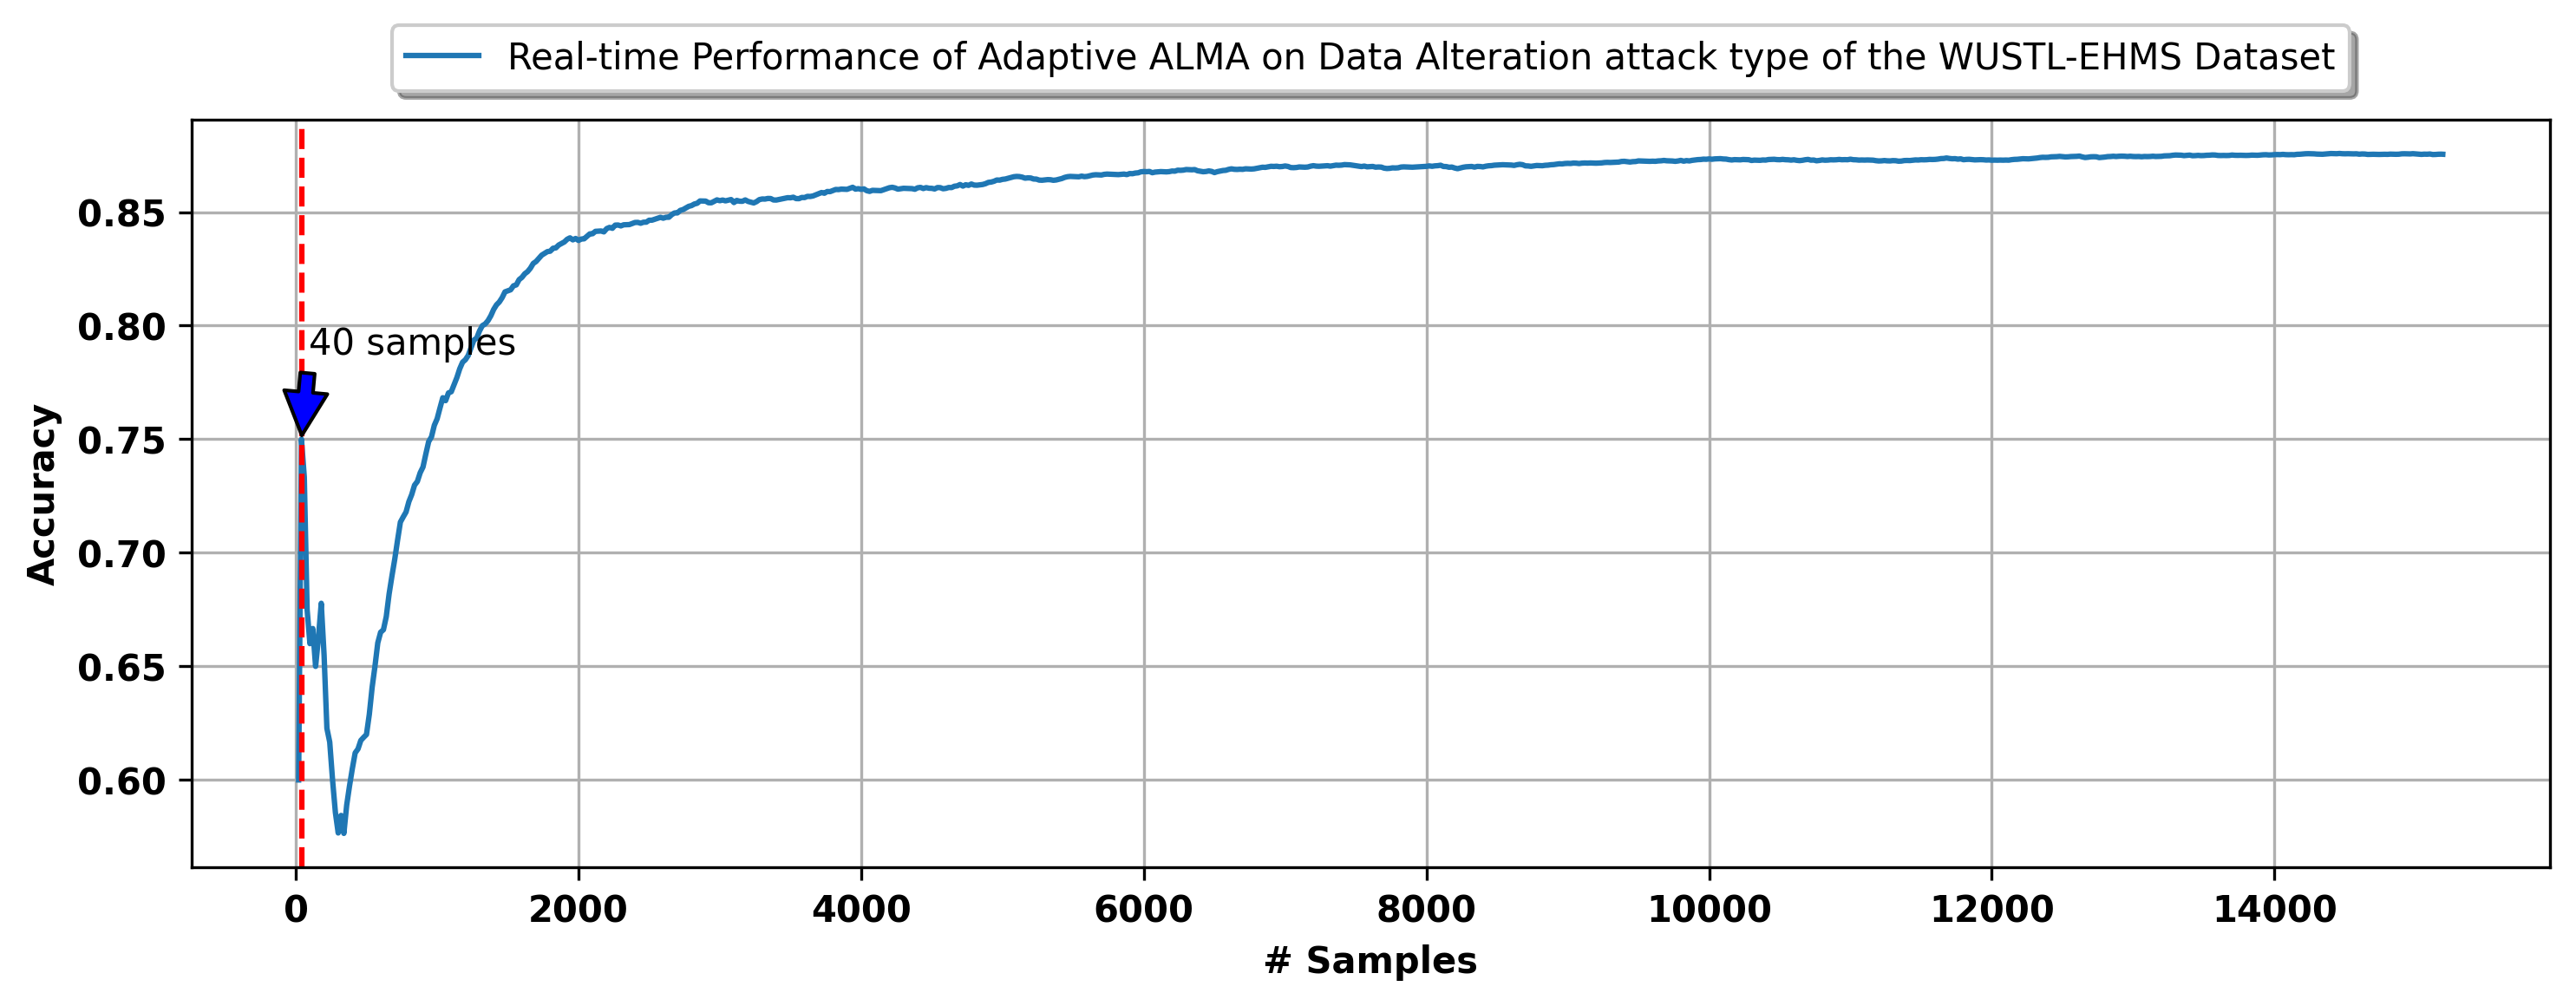

In [10]:
plot_performance(
    dataset,
    metrics.Accuracy(),
    {
        "Real-time Performance of Adaptive ALMA on Data Alteration attack type of the WUSTL-EHMS Dataset": (
            preprocessing.StandardScaler() | AdaptiveALMA()
        )
    }
)

In [11]:
#Loading the dataset
df= pd.read_csv("/Users/promisea/ALMA/EHMS/EHMS_Spoofing_Attack.csv")
print('Original dataset shape  %s' % Counter(df['Label']))
X = df.drop(['Label'], axis=1)
y = df['Label']
X, y = shuffle(X, y, random_state=42)
dataset = stream.iter_pandas(X, y)

Original dataset shape  Counter({0: 14269, 1: 1124})


In [12]:
ALMA = compose.Pipeline(
    preprocessing.StandardScaler(),
    ln.ALMAClassifier()
)

#Passing the evalaution metrics into a variable
report = metrics.ClassificationReport()

In [13]:
%%time

evaluate.progressive_val_score(dataset, ALMA, report, print_every=5000, show_time=True, show_memory=True)

[5,000]            Precision   Recall   F1       Support  
                                                  
       0      93.54%   52.92%   67.60%      4650  
       1       7.60%   51.43%   13.24%       350  
                                                  
   Macro      50.57%   52.18%   40.42%            
   Micro      52.82%   52.82%   52.82%            
Weighted      87.52%   52.82%   63.80%            

                 52.82% accuracy                   – 00:00:00 – 12.87 KB
[10,000]            Precision   Recall   F1       Support  
                                                  
       0      93.29%   52.67%   67.33%      9295  
       1       7.43%   50.07%   12.94%       705  
                                                  
   Macro      50.36%   51.37%   40.13%            
   Micro      52.49%   52.49%   52.49%            
Weighted      87.24%   52.49%   63.50%            

                 52.49% accuracy                   – 00:00:00 – 12.87 KB
[15,000]           

           Precision   Recall   F1       Support  
                                                  
       0      93.12%   52.37%   67.03%     14269  
       1       7.76%   50.89%   13.47%      1124  
                                                  
   Macro      50.44%   51.63%   40.25%            
   Micro      52.26%   52.26%   52.26%            
Weighted      86.89%   52.26%   63.12%            

                 52.26% accuracy                  

In [14]:
dataset = stream.iter_pandas(X, y)

In [15]:
model = compose.Pipeline(
    preprocessing.StandardScaler(),
    AdaptiveALMA()
)

#Passing the evalaution metrics into a variable
report = metrics.ClassificationReport()

In [16]:
%%time

evaluate.progressive_val_score(dataset, model, report, print_every=5000, show_time=True, show_memory=True)

[5,000]            Precision   Recall   F1       Support  
                                                  
       0      92.91%   64.49%   76.14%      4650  
       1       6.83%   34.57%   11.40%       350  
                                                  
   Macro      49.87%   49.53%   43.77%            
   Micro      62.40%   62.40%   62.40%            
Weighted      86.88%   62.40%   71.60%            

                 62.40% accuracy                   – 00:00:00 – 19.91 KB
[10,000]            Precision   Recall   F1       Support  
                                                  
       0      92.98%   65.65%   76.96%      9295  
       1       7.10%   34.61%   11.78%       705  
                                                  
   Macro      50.04%   50.13%   44.37%            
   Micro      63.46%   63.46%   63.46%            
Weighted      86.92%   63.46%   72.36%            

                 63.46% accuracy                   – 00:00:01 – 19.85 KB
[15,000]           

           Precision   Recall   F1       Support  
                                                  
       0      92.52%   65.76%   76.88%     14269  
       1       6.95%   32.47%   11.45%      1124  
                                                  
   Macro      49.73%   49.12%   44.17%            
   Micro      63.33%   63.33%   63.33%            
Weighted      86.27%   63.33%   72.10%            

                 63.33% accuracy                  

In [17]:
dataset = stream.iter_pandas(X, y)

In [18]:
def plot_performance(dataset, metric, models):
    metric_name = metric.__class__.__name__
    
    # Creating a single plot for accuracy
    fig, ax = plt.subplots(figsize=(10, 4), dpi=300)
    threshold_reached_step = None  # To store the step where accuracy reaches 75%

    for model_name, model in models.items():
        steps = []
        accuracies = []

        for checkpoint in evaluate.iter_progressive_val_score(
            dataset, model, metric, measure_time=False, measure_memory=False, step=20
        ):
            current_step = checkpoint["Step"]
            current_accuracy = checkpoint[metric_name].get()
            steps.append(current_step)
            accuracies.append(current_accuracy)

            # Check if the accuracy reaches 75% for the first time
            if current_accuracy >= 0.75 and threshold_reached_step is None:
                threshold_reached_step = current_step

        ax.plot(steps, accuracies, label=model_name)

        # Draw a vertical red line and annotate if the threshold is reached
        if threshold_reached_step:
            ax.axvline(x=threshold_reached_step, color='red', linestyle='--')
            ax.annotate(f'{threshold_reached_step} samples', xy=(threshold_reached_step, 0.75),
                        xytext=(threshold_reached_step + 50, 0.80),
                        arrowprops=dict(facecolor='blue', shrink=0.05),
                        horizontalalignment='left', verticalalignment='top')

    ax.set_ylabel('Accuracy', fontweight='bold')
    ax.set_xlabel('#Samples', fontweight='bold')
    ax.grid(True)
    ax.legend(
        loc='upper center', bbox_to_anchor=(0.5, 1.15),
        ncol=1, fancybox=True, shadow=True
    )
    
    # Apply bold formatting directly to tick labels
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')

    plt.tight_layout()
    plt.savefig('Spoofing_EHMS.png')
    plt.close()

    return fig

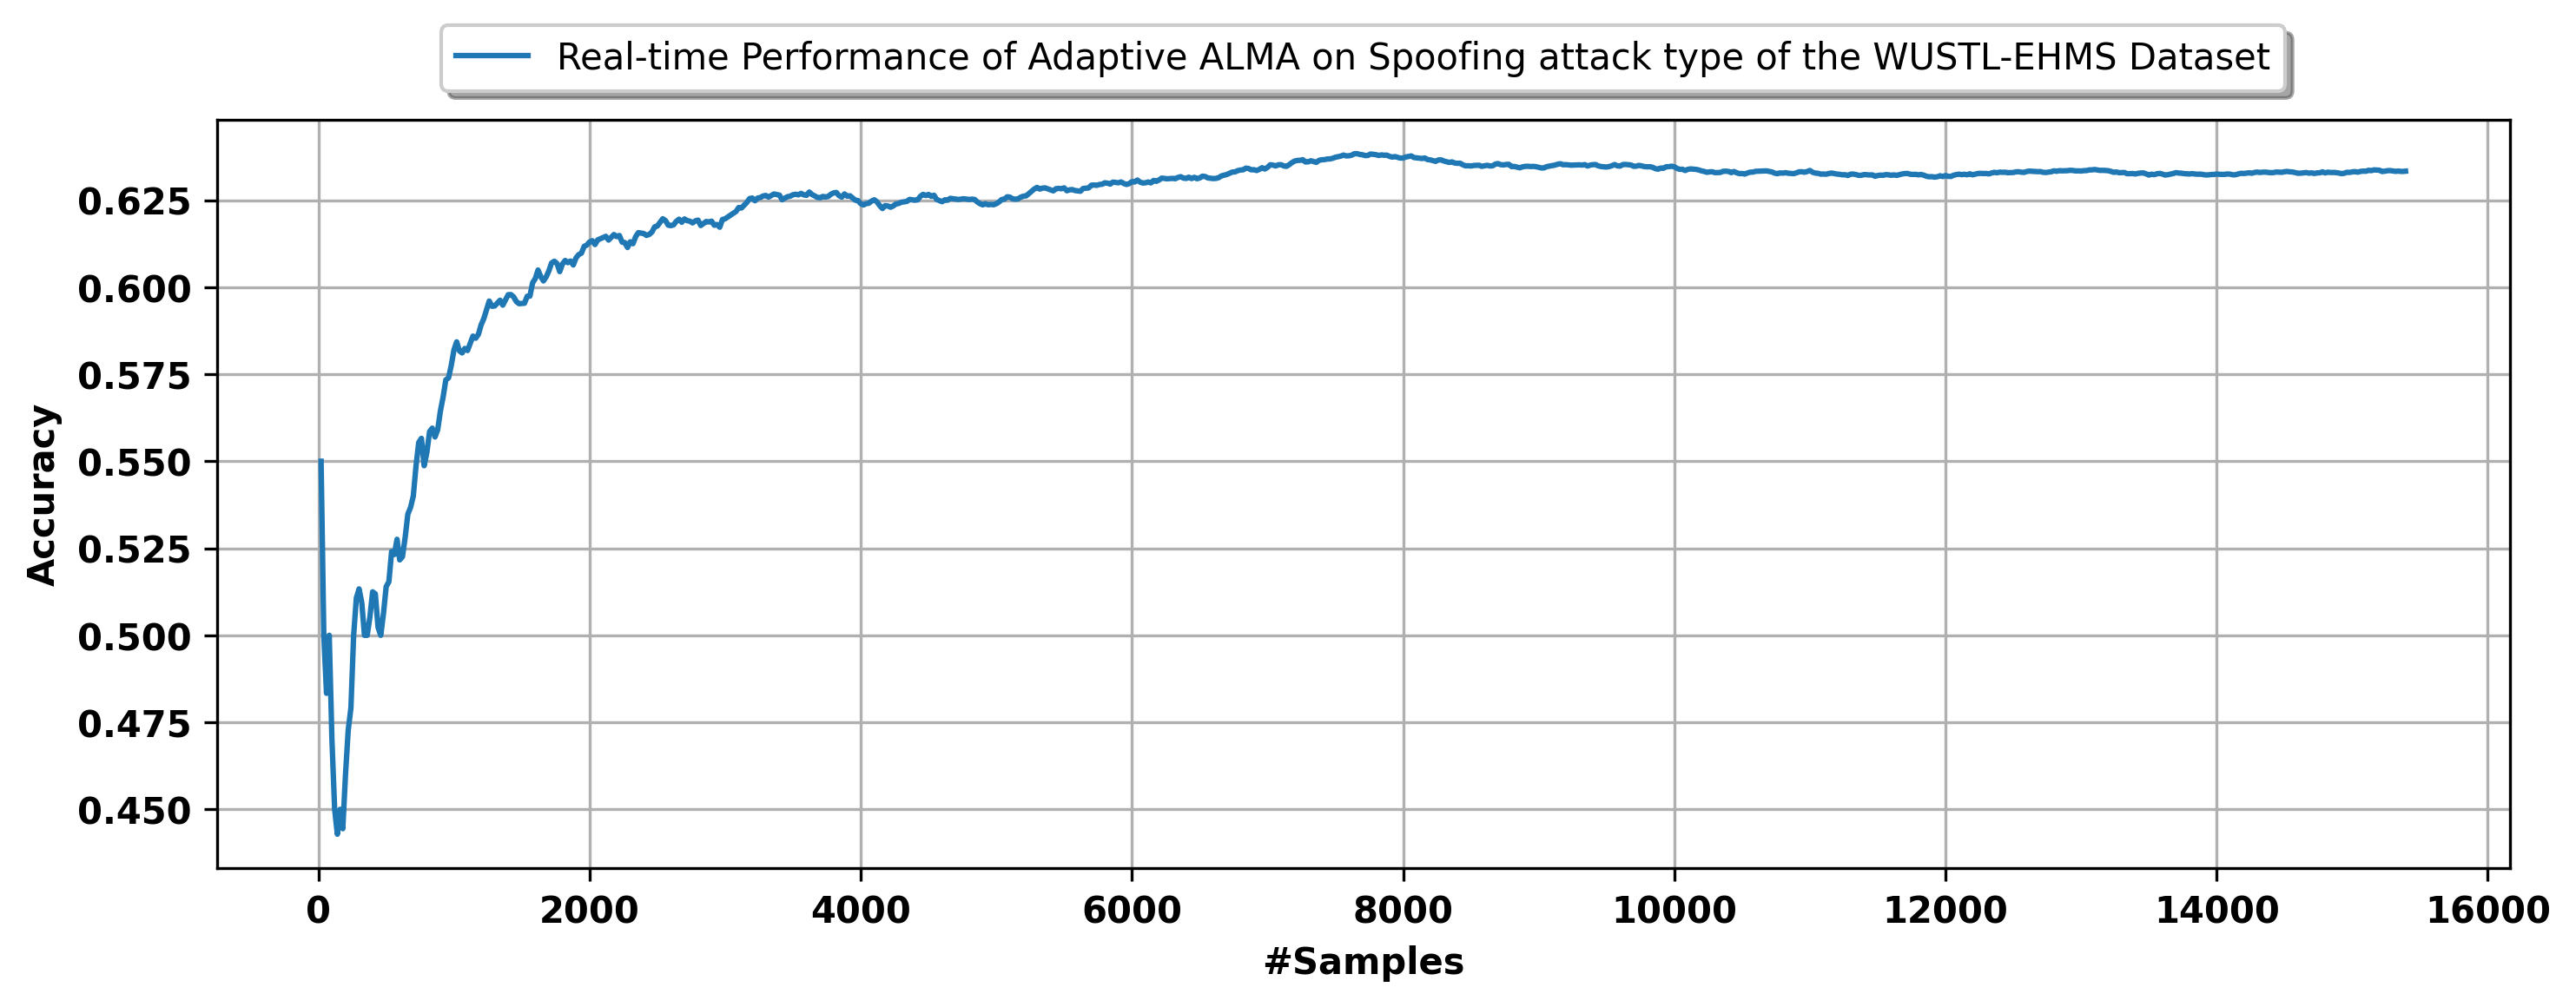

In [19]:
plot_performance(
    dataset,
    metrics.Accuracy(),
    {
        "Real-time Performance of Adaptive ALMA on Spoofing attack type of the WUSTL-EHMS Dataset": (
            preprocessing.StandardScaler() | AdaptiveALMA()
        )
    }
)

In [20]:
#Loading the dataset
df = pd.read_csv("/Users/promisea/ALMA/EHMS/EHMS_Benign_Only.csv")
df1= pd.read_csv("/Users/promisea/ALMA/EHMS/EHMS_Alteration_Only.csv")
df2= pd.read_csv("/Users/promisea/ALMA/EHMS/EHMS_Spoofing_Only.csv")
X = df.drop(['Label'], axis=1)
y = df['Label']
X1 = df1.drop(['Label'], axis=1)
y1 = df1['Label']
X2 = df2.drop(['Label'], axis=1)
y2 = df2['Label']
X3 = pd.concat([X, X1, X2])
y3 = pd.concat([y, y1, y2])
X3, y3 = shuffle(X3, y3, random_state=42)
dataset = stream.iter_pandas(X3, y3)

In [21]:
model = compose.Pipeline(
    preprocessing.StandardScaler(),
    AdaptiveALMA()
)

#Passing the evalaution metrics into a variable
report = metrics.ClassificationReport()

In [22]:
%%time

evaluate.progressive_val_score(dataset, model, report, print_every=5000, show_time=True, show_memory=True)

[5,000]            Precision   Recall   F1       Support  
                                                  
       0      92.71%   87.23%   89.89%      4401  
       1      34.58%   49.58%   40.74%       599  
                                                  
   Macro      63.64%   68.41%   65.31%            
   Micro      82.72%   82.72%   82.72%            
Weighted      85.74%   82.72%   84.00%            

                 82.72% accuracy                   – 00:00:00 – 19.8 KB
[10,000]            Precision   Recall   F1       Support  
                                                  
       0      92.75%   87.77%   90.19%      8754  
       1      37.59%   51.77%   43.55%      1246  
                                                  
   Macro      65.17%   69.77%   66.87%            
   Micro      83.28%   83.28%   83.28%            
Weighted      85.87%   83.28%   84.38%            

                 83.28% accuracy                   – 00:00:00 – 19.77 KB
[15,000]            

           Precision   Recall   F1       Support  
                                                  
       0      92.71%   88.00%   90.30%     14269  
       1      38.22%   51.76%   43.97%      2046  
                                                  
   Macro      65.46%   69.88%   67.13%            
   Micro      83.46%   83.46%   83.46%            
Weighted      85.88%   83.46%   84.49%            

                 83.46% accuracy                  

In [23]:
#Loading the dataset
df= pd.read_csv("/Users/promisea/ALMA/EHMS/EHMS_Spoofing_Attack.csv")
print('Original dataset shape  %s' % Counter(df['Label']))
X = df.drop(['Label'], axis=1)
y = df['Label']
X, y = shuffle(X, y, random_state=42)

Original dataset shape  Counter({0: 14269, 1: 1124})


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.95, random_state=100, stratify=df['Label'] )

model = compose.Pipeline(
    preprocessing.StandardScaler(),
    AdaptiveALMA()
)

dataset = stream.iter_pandas(X_train, y_train)

#Passing the evalaution metrics into a variable
report = metrics.ClassificationReport()

In [25]:
%%time

evaluate.progressive_val_score(dataset, model, report, print_every=500, show_time=True, show_memory=True)

[500]            Precision   Recall   F1       Support  
                                                  
       0      92.66%   57.11%   70.67%       464  
       1       7.01%   41.67%   12.00%        36  
                                                  
   Macro      49.83%   49.39%   41.33%            
   Micro      56.00%   56.00%   56.00%            
Weighted      86.49%   56.00%   66.44%            

                 56.00% accuracy                   – 00:00:00 – 19.83 KB
[769]            Precision   Recall   F1       Support  
                                                  
       0      92.18%   69.72%   79.39%       710  
       1       7.33%   28.81%   11.68%        59  
                                                  
   Macro      49.75%   49.27%   45.54%            
   Micro      66.58%   66.58%   66.58%            
Weighted      85.67%   66.58%   74.20%            

                 66.58% accuracy                   – 00:00:00 – 19.83 KB
CPU times: user 82.8 ms,

           Precision   Recall   F1       Support  
                                                  
       0      92.18%   69.72%   79.39%       710  
       1       7.33%   28.81%   11.68%        59  
                                                  
   Macro      49.75%   49.27%   45.54%            
   Micro      66.58%   66.58%   66.58%            
Weighted      85.67%   66.58%   74.20%            

                 66.58% accuracy                  

In [26]:
# Initialize metrics
Acc = metrics.Accuracy()
Pre = metrics.Precision()
Rec = metrics.Recall()
F1 = metrics.F1()

# Iterate over the test stream and update metrics
for xi, yi in stream.iter_pandas(X_test, y_test):
    y_pred = model.predict_one(xi)
    Acc.update(yi, y_pred)
    Pre.update(yi, y_pred)
    Rec.update(yi, y_pred)
    F1.update(yi, y_pred)

# Retrieve final metric values
Accuracy = Acc.get()
Precision = Pre.get()
Recall = Rec.get()
F1_Score = F1.get()

# Output the results
print("Printing the results for 95% unseen samples")
print("Accuracy:", Accuracy)
print("Precision:", Precision)
print("Recall:", Recall)
print("F1_Score:", F1_Score)

Printing the results for 95% unseen samples
Accuracy: 0.8946252735229759
Precision: 0.06884057971014493
Recall: 0.03568075117370892
F1_Score: 0.04700061842918986


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.90, random_state=100, stratify=df['Label'])

model = compose.Pipeline(
    preprocessing.StandardScaler(),
    AdaptiveALMA()
)

dataset = stream.iter_pandas(X_train, y_train)

#Passing the evalaution metrics into a variable
report = metrics.ClassificationReport()

In [28]:
%%time

evaluate.progressive_val_score(dataset, model, report, print_every=500, show_time=True, show_memory=True)

[500]            Precision   Recall   F1       Support  
                                                  
       0      96.24%   54.12%   69.28%       473  
       1       7.26%   62.96%   13.03%        27  
                                                  
   Macro      51.75%   58.54%   41.15%            
   Micro      54.60%   54.60%   54.60%            
Weighted      91.44%   54.60%   66.24%            

                 54.60% accuracy                   – 00:00:00 – 19.8 KB
[1,000]            Precision   Recall   F1       Support  
                                                  
       0      94.17%   72.23%   81.76%       940  
       1       6.45%   30.00%   10.62%        60  
                                                  
   Macro      50.31%   51.12%   46.19%            
   Micro      69.70%   69.70%   69.70%            
Weighted      88.91%   69.70%   77.49%            

                 69.70% accuracy                   – 00:00:00 – 20.41 KB
[1,500]            Prec

           Precision   Recall   F1       Support  
                                                  
       0      93.66%   78.96%   85.68%      1440  
       1       6.77%   22.22%   10.38%        99  
                                                  
   Macro      50.21%   50.59%   48.03%            
   Micro      75.31%   75.31%   75.31%            
Weighted      88.07%   75.31%   80.84%            

                 75.31% accuracy                  

In [29]:
# Initialize metrics
Acc = metrics.Accuracy()
Pre = metrics.Precision()
Rec = metrics.Recall()
F1 = metrics.F1()

# Iterate over the test stream and update metrics
for xi, yi in stream.iter_pandas(X_test, y_test):
    y_pred = model.predict_one(xi)
    Acc.update(yi, y_pred)
    Pre.update(yi, y_pred)
    Rec.update(yi, y_pred)
    F1.update(yi, y_pred)

# Retrieve final metric values
Accuracy = Acc.get()
Precision = Pre.get()
Recall = Rec.get()
F1_Score = F1.get()

# Output the results
print("Printing the results for 90% unseen samples")
print("Accuracy:", Accuracy)
print("Precision:", Precision)
print("Recall:", Recall)
print("F1_Score:", F1_Score)

Printing the results for 90% unseen samples
Accuracy: 0.8593186083441605
Precision: 0.08896797153024912
Recall: 0.0975609756097561
F1_Score: 0.09306654257794322


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.85, random_state=100, stratify=df['Label'])

model = compose.Pipeline(
    preprocessing.StandardScaler(),
    AdaptiveALMA()
)

dataset = stream.iter_pandas(X_train, y_train)

#Passing the evalaution metrics into a variable
report = metrics.ClassificationReport()

In [31]:
%%time

evaluate.progressive_val_score(dataset, model, report, print_every=500, show_time=True, show_memory=True)

[500]            Precision   Recall   F1       Support  
                                                  
       0      93.92%   59.53%   72.87%       467  
       1       7.35%   45.45%   12.66%        33  
                                                  
   Macro      50.64%   52.49%   42.76%            
   Micro      58.60%   58.60%   58.60%            
Weighted      88.21%   58.60%   68.90%            

                 58.60% accuracy                   – 00:00:00 – 20 KB
[1,000]            Precision   Recall   F1       Support  
                                                  
       0      93.73%   71.98%   81.43%       935  
       1       7.09%   30.77%   11.53%        65  
                                                  
   Macro      50.41%   51.37%   46.48%            
   Micro      69.30%   69.30%   69.30%            
Weighted      88.10%   69.30%   76.88%            

                 69.30% accuracy                   – 00:00:00 – 20.38 KB
[1,500]            Precis

           Precision   Recall   F1       Support  
                                                  
       0      93.89%   78.06%   85.25%      2165  
       1       6.50%   23.08%   10.14%       143  
                                                  
   Macro      50.19%   50.57%   47.69%            
   Micro      74.65%   74.65%   74.65%            
Weighted      88.47%   74.65%   80.59%            

                 74.65% accuracy                  

In [32]:
# Initialize metrics
Acc = metrics.Accuracy()
Pre = metrics.Precision()
Rec = metrics.Recall()
F1 = metrics.F1()

# Iterate over the test stream and update metrics
for xi, yi in stream.iter_pandas(X_test, y_test):
    y_pred = model.predict_one(xi)
    Acc.update(yi, y_pred)
    Pre.update(yi, y_pred)
    Rec.update(yi, y_pred)
    F1.update(yi, y_pred)

# Retrieve final metric values
Accuracy = Acc.get()
Precision = Pre.get()
Recall = Rec.get()
F1_Score = F1.get()

# Output the results
print("Printing the results for 85% unseen samples")
print("Accuracy:", Accuracy)
print("Precision:", Precision)
print("Recall:", Recall)
print("F1_Score:", F1_Score)

Printing the results for 85% unseen samples
Accuracy: 0.7993886129155522
Precision: 0.08103975535168195
Recall: 0.1620795107033639
F1_Score: 0.10805300713557593


In [33]:
#Loading the dataset
df= pd.read_csv("/Users/promisea/ALMA/EHMS/EHMS_Alteration_Attack.csv")
print('Original dataset shape  %s' % Counter(df['Label']))
X = df.drop(['Label'], axis=1)
y = df['Label']
X, y = shuffle(X, y, random_state=42)

Original dataset shape  Counter({0: 14269, 1: 922})


In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.95, random_state=100, stratify=df['Label'])

model = compose.Pipeline(
    preprocessing.StandardScaler(),
    AdaptiveALMA()
)

dataset = stream.iter_pandas(X_train, y_train)

#Passing the evalaution metrics into a variable
report = metrics.ClassificationReport()

In [35]:
%%time

evaluate.progressive_val_score(dataset, model, report, print_every=500, show_time=True, show_memory=True)

[500]            Precision   Recall   F1       Support  
                                                  
       0      99.38%   68.52%   81.12%       467  
       1      17.42%   93.94%   29.38%        33  
                                                  
   Macro      58.40%   81.23%   55.25%            
   Micro      70.20%   70.20%   70.20%            
Weighted      93.97%   70.20%   77.70%            

                 70.20% accuracy                   – 00:00:00 – 19.8 KB
[759]            Precision   Recall   F1       Support  
                                                  
       0      99.64%   77.86%   87.41%       709  
       1      23.41%   96.00%   37.65%        50  
                                                  
   Macro      61.53%   86.93%   62.53%            
   Micro      79.05%   79.05%   79.05%            
Weighted      94.62%   79.05%   84.13%            

                 79.05% accuracy                   – 00:00:00 – 19.77 KB
CPU times: user 77.1 ms, 

           Precision   Recall   F1       Support  
                                                  
       0      99.64%   77.86%   87.41%       709  
       1      23.41%   96.00%   37.65%        50  
                                                  
   Macro      61.53%   86.93%   62.53%            
   Micro      79.05%   79.05%   79.05%            
Weighted      94.62%   79.05%   84.13%            

                 79.05% accuracy                  

In [36]:
# Initialize metrics
Acc = metrics.Accuracy()
Pre = metrics.Precision()
Rec = metrics.Recall()
F1 = metrics.F1()

# Iterate over the test stream and update metrics
for xi, yi in stream.iter_pandas(X_test, y_test):
    y_pred = model.predict_one(xi)
    Acc.update(yi, y_pred)
    Pre.update(yi, y_pred)
    Rec.update(yi, y_pred)
    F1.update(yi, y_pred)

# Retrieve final metric values
Accuracy = Acc.get()
Precision = Pre.get()
Recall = Rec.get()
F1_Score = F1.get()

# Output the results
print("Printing the results for 95% unseen samples")
print("Accuracy:", Accuracy)
print("Precision:", Precision)
print("Recall:", Recall)
print("F1_Score:", F1_Score)

Printing the results for 95% unseen samples
Accuracy: 0.9376385809312638
Precision: 0.492018244013683
Recall: 0.9896788990825688
F1_Score: 0.6572734196496572


In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.90, random_state=100, stratify=df['Label'])

model = compose.Pipeline(
    preprocessing.StandardScaler(),
    AdaptiveALMA()
)

dataset = stream.iter_pandas(X_train, y_train)

#Passing the evalaution metrics into a variable
report = metrics.ClassificationReport()

In [38]:
%%time

evaluate.progressive_val_score(dataset, model, report, print_every=500, show_time=True, show_memory=True)

[500]            Precision   Recall   F1       Support  
                                                  
       0      99.09%   68.55%   81.04%       477  
       1      11.76%   86.96%   20.73%        23  
                                                  
   Macro      55.43%   77.75%   50.88%            
   Micro      69.40%   69.40%   69.40%            
Weighted      95.07%   69.40%   78.27%            

                 69.40% accuracy                   – 00:00:00 – 19.74 KB
[1,000]            Precision   Recall   F1       Support  
                                                  
       0      99.60%   79.28%   88.29%       946  
       1      20.65%   94.44%   33.89%        54  
                                                  
   Macro      60.12%   86.86%   61.09%            
   Micro      80.10%   80.10%   80.10%            
Weighted      95.34%   80.10%   85.35%            

                 80.10% accuracy                   – 00:00:00 – 20.29 KB
[1,500]            Pre

           Precision   Recall   F1       Support  
                                                  
       0      99.75%   84.18%   91.31%      1435  
       1      26.30%   96.43%   41.33%        84  
                                                  
   Macro      63.03%   90.30%   66.32%            
   Micro      84.86%   84.86%   84.86%            
Weighted      95.69%   84.86%   88.54%            

                 84.86% accuracy                  

In [39]:
# Initialize metrics
Acc = metrics.Accuracy()
Pre = metrics.Precision()
Rec = metrics.Recall()
F1 = metrics.F1()

# Iterate over the test stream and update metrics
for xi, yi in stream.iter_pandas(X_test, y_test):
    y_pred = model.predict_one(xi)
    Acc.update(yi, y_pred)
    Pre.update(yi, y_pred)
    Rec.update(yi, y_pred)
    F1.update(yi, y_pred)

# Retrieve final metric values
Accuracy = Acc.get()
Precision = Pre.get()
Recall = Rec.get()
F1_Score = F1.get()

# Output the results
print("Printing the results for 90% unseen samples")
print("Accuracy:", Accuracy)
print("Precision:", Precision)
print("Recall:", Recall)
print("F1_Score:", F1_Score)

Printing the results for 90% unseen samples
Accuracy: 0.9414862492685782
Precision: 0.5115995115995116
Recall: 1.0
F1_Score: 0.6768982229402262


In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.85, random_state=100, stratify=df['Label'])

model = compose.Pipeline(
    preprocessing.StandardScaler(),
    AdaptiveALMA()
)

dataset = stream.iter_pandas(X_train, y_train)

#Passing the evalaution metrics into a variable
report = metrics.ClassificationReport()

In [41]:
%%time

evaluate.progressive_val_score(dataset, model, report, print_every=500, show_time=True, show_memory=True)

[500]            Precision   Recall   F1       Support  
                                                  
       0      98.10%   65.54%   78.58%       473  
       1      11.41%   77.78%   19.91%        27  
                                                  
   Macro      54.76%   71.66%   49.24%            
   Micro      66.20%   66.20%   66.20%            
Weighted      93.42%   66.20%   75.41%            

                 66.20% accuracy                   – 00:00:00 – 19.74 KB
[1,000]            Precision   Recall   F1       Support  
                                                  
       0      99.16%   75.34%   85.63%       945  
       1      17.38%   89.09%   29.08%        55  
                                                  
   Macro      58.27%   82.22%   57.35%            
   Micro      76.10%   76.10%   76.10%            
Weighted      94.67%   76.10%   82.52%            

                 76.10% accuracy                   – 00:00:00 – 20.29 KB
[1,500]            Pre

           Precision   Recall   F1       Support  
                                                  
       0      99.65%   79.54%   88.46%      2155  
       1      20.97%   95.12%   34.36%       123  
                                                  
   Macro      60.31%   87.33%   61.41%            
   Micro      80.38%   80.38%   80.38%            
Weighted      95.40%   80.38%   85.54%            

                 80.38% accuracy                  

In [42]:
# Initialize metrics
Acc = metrics.Accuracy()
Pre = metrics.Precision()
Rec = metrics.Recall()
F1 = metrics.F1()

# Iterate over the test stream and update metrics
for xi, yi in stream.iter_pandas(X_test, y_test):
    y_pred = model.predict_one(xi)
    Acc.update(yi, y_pred)
    Pre.update(yi, y_pred)
    Rec.update(yi, y_pred)
    F1.update(yi, y_pred)

# Retrieve final metric values
Accuracy = Acc.get()
Precision = Pre.get()
Recall = Rec.get()
F1_Score = F1.get()

# Output the results
print("Printing the results for 85% unseen samples")
print("Accuracy:", Accuracy)
print("Precision:", Precision)
print("Recall:", Recall)
print("F1_Score:", F1_Score)

Printing the results for 85% unseen samples
Accuracy: 0.8307906760628824
Precision: 0.26776139410187666
Recall: 1.0
F1_Score: 0.422416071900608


In [43]:
#Loading the dataset
df= pd.read_csv("/Users/promisea/ALMA/EHMS/ehms.csv")
print('Original dataset shape  %s' % Counter(df['Label']))
X = df.drop(['Label'], axis=1)
y = df['Label']
X, y = shuffle(X, y, random_state=42)

Original dataset shape  Counter({0: 14269, 1: 2046})


In [44]:
ALMA = compose.Pipeline(
    preprocessing.StandardScaler(),
    AdaptiveALMA()
)

dataset = stream.iter_pandas(X, y)

#Passing the evalaution metrics into a variable
report = metrics.ClassificationReport()

In [45]:
%%time

evaluate.progressive_val_score(dataset, ALMA, report, print_every=5000, show_time=True, show_memory=True)

[5,000]            Precision   Recall   F1       Support  
                                                  
       0      92.55%   81.58%   86.72%      4370  
       1      29.88%   54.44%   38.58%       630  
                                                  
   Macro      61.21%   68.01%   62.65%            
   Micro      78.16%   78.16%   78.16%            
Weighted      84.65%   78.16%   80.65%            

                 78.16% accuracy                   – 00:00:00 – 19.8 KB
[10,000]            Precision   Recall   F1       Support  
                                                  
       0      92.59%   81.33%   86.60%      8742  
       1      29.69%   54.77%   38.50%      1258  
                                                  
   Macro      61.14%   68.05%   62.55%            
   Micro      77.99%   77.99%   77.99%            
Weighted      84.68%   77.99%   80.55%            

                 77.99% accuracy                   – 00:00:01 – 19.85 KB
[15,000]            

           Precision   Recall   F1       Support  
                                                  
       0      92.66%   81.00%   86.44%     14269  
       1      29.42%   55.23%   38.39%      2046  
                                                  
   Macro      61.04%   68.12%   62.41%            
   Micro      77.77%   77.77%   77.77%            
Weighted      84.73%   77.77%   80.41%            

                 77.77% accuracy                  

In [46]:
dataset = stream.iter_pandas(X, y)

In [47]:
model = compose.Pipeline(
    preprocessing.StandardScaler(),
    AdaptiveALMA()
)

dataset = stream.iter_pandas(X, y)

#Passing the evalaution metrics into a variable
report = metrics.ClassificationReport()

In [48]:
%%time

evaluate.progressive_val_score(dataset, model, report, print_every=5000, show_time=True, show_memory=True)

[5,000]            Precision   Recall   F1       Support  
                                                  
       0      92.55%   81.58%   86.72%      4370  
       1      29.88%   54.44%   38.58%       630  
                                                  
   Macro      61.21%   68.01%   62.65%            
   Micro      78.16%   78.16%   78.16%            
Weighted      84.65%   78.16%   80.65%            

                 78.16% accuracy                   – 00:00:00 – 19.8 KB
[10,000]            Precision   Recall   F1       Support  
                                                  
       0      92.59%   81.33%   86.60%      8742  
       1      29.69%   54.77%   38.50%      1258  
                                                  
   Macro      61.14%   68.05%   62.55%            
   Micro      77.99%   77.99%   77.99%            
Weighted      84.68%   77.99%   80.55%            

                 77.99% accuracy                   – 00:00:01 – 19.85 KB
[15,000]            

           Precision   Recall   F1       Support  
                                                  
       0      92.66%   81.00%   86.44%     14269  
       1      29.42%   55.23%   38.39%      2046  
                                                  
   Macro      61.04%   68.12%   62.41%            
   Micro      77.77%   77.77%   77.77%            
Weighted      84.73%   77.77%   80.41%            

                 77.77% accuracy                  

In [49]:
dataset = stream.iter_pandas(X, y)

In [50]:
def plot_performance(dataset, metric, models):
    metric_name = metric.__class__.__name__
    
    # Creating a single plot for accuracy
    fig, ax = plt.subplots(figsize=(10, 4), dpi=300)
    threshold_reached_step = None  # To store the step where accuracy reaches 75%

    for model_name, model in models.items():
        steps = []
        accuracies = []

        for checkpoint in evaluate.iter_progressive_val_score(
            dataset, model, metric, measure_time=False, measure_memory=False, step=20
        ):
            current_step = checkpoint["Step"]
            current_accuracy = checkpoint[metric_name].get()
            steps.append(current_step)
            accuracies.append(current_accuracy)

            # Check if the accuracy reaches 75% for the first time
            if current_accuracy >= 0.75 and threshold_reached_step is None:
                threshold_reached_step = current_step

        ax.plot(steps, accuracies, label=model_name)

        # Draw a vertical red line and annotate if the threshold is reached
        if threshold_reached_step:
            ax.axvline(x=threshold_reached_step, color='red', linestyle='--')
            ax.annotate(f'{threshold_reached_step} samples', xy=(threshold_reached_step, 0.75),
                        xytext=(threshold_reached_step + 50, 0.80),
                        arrowprops=dict(facecolor='blue', shrink=0.05),
                        horizontalalignment='left', verticalalignment='top')

    ax.set_ylabel('Accuracy', fontweight='bold')
    ax.set_xlabel('#Samples', fontweight='bold')
    ax.grid(True)
    ax.legend(
        loc='upper center', bbox_to_anchor=(0.5, 1.15),
        ncol=1, fancybox=True, shadow=True
    )
    
    # Apply bold formatting directly to tick labels
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')

    plt.tight_layout()
    plt.savefig('Performance_ALMA_EHMS.png')
    plt.close()

    return fig

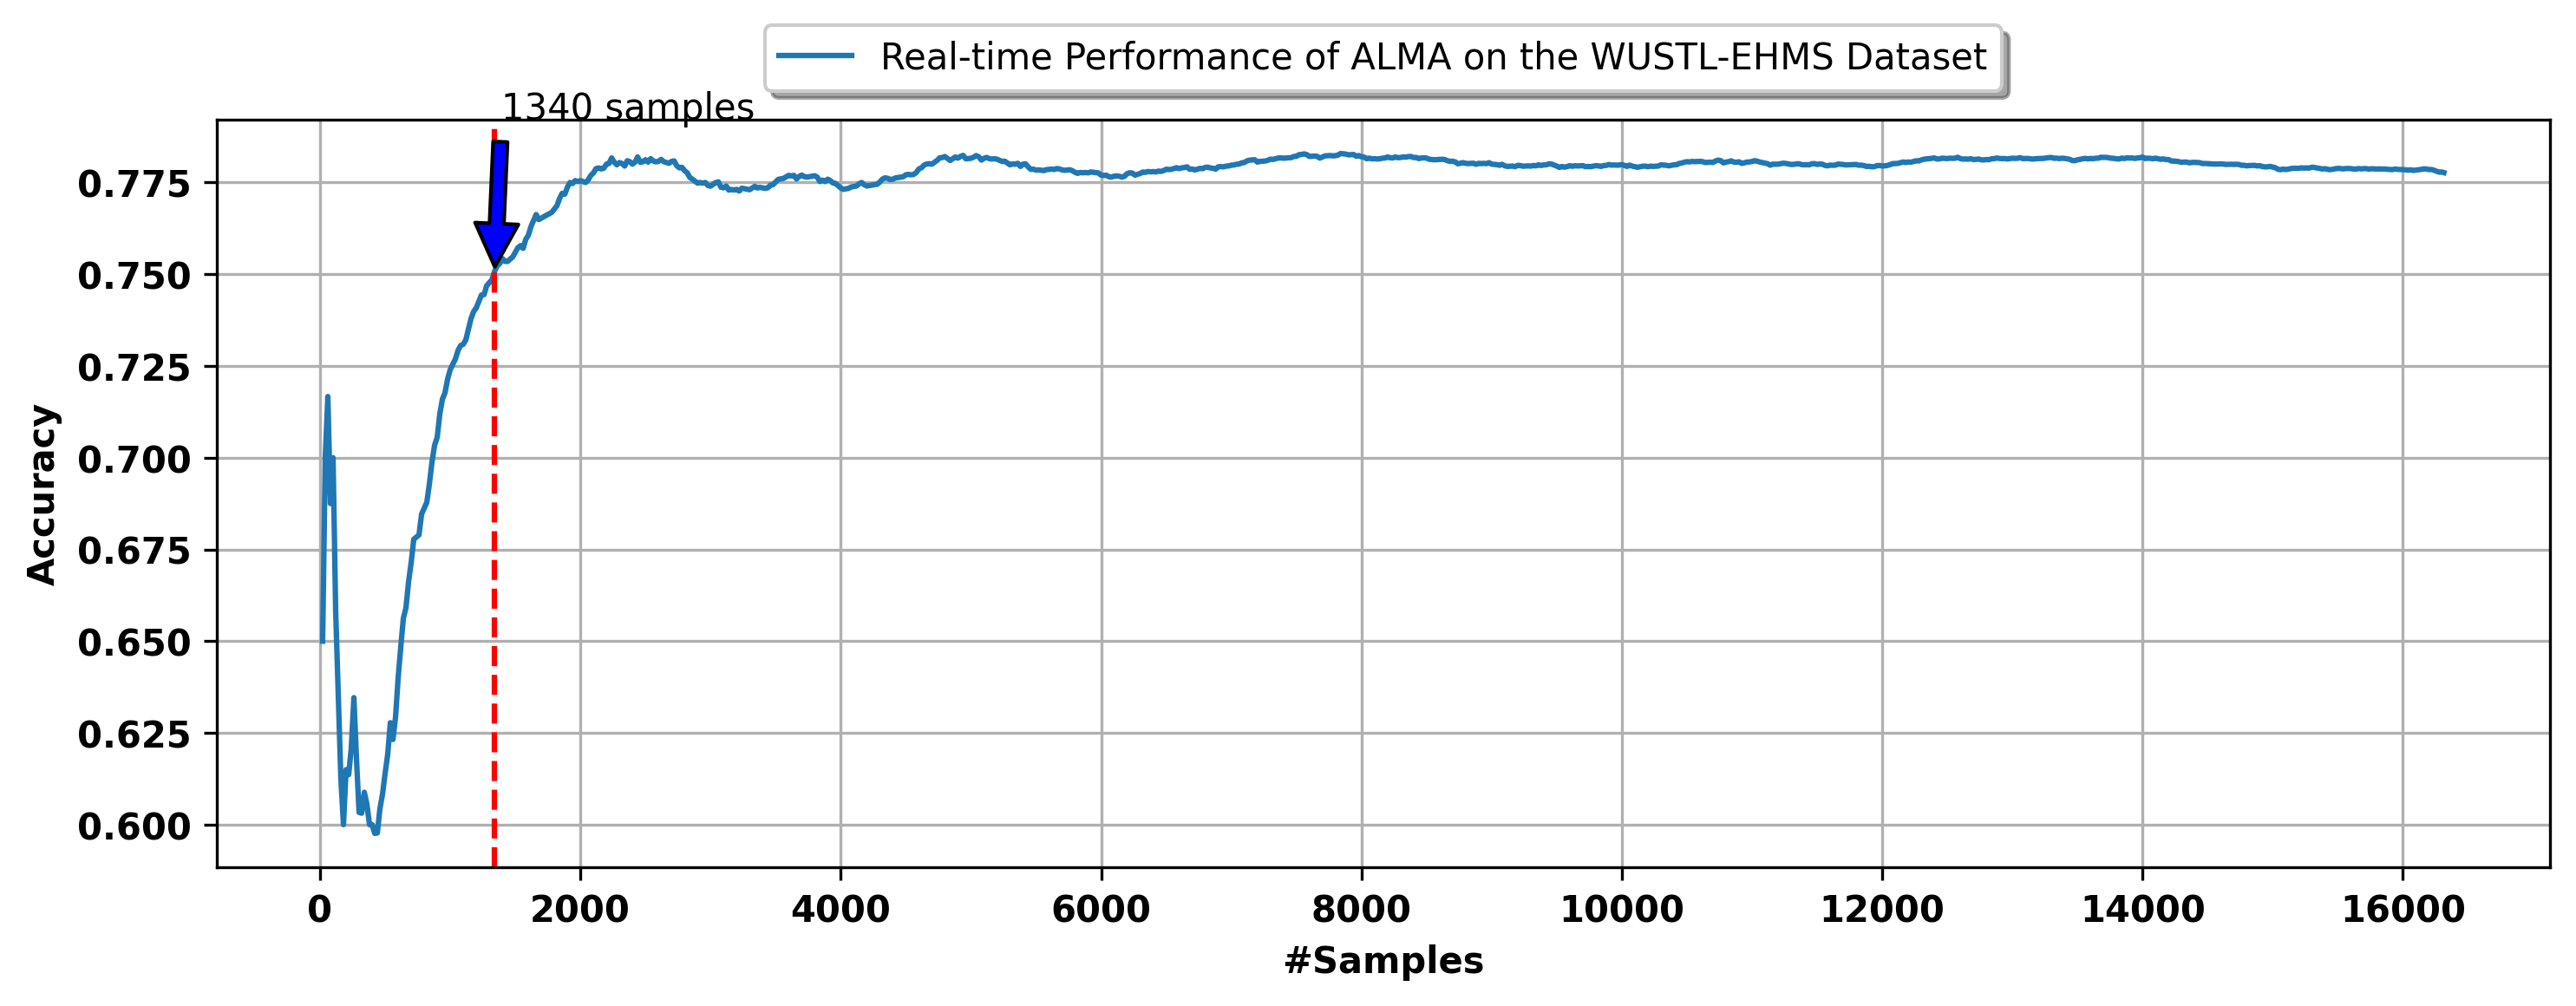

In [51]:
plot_performance(
    dataset,
    metrics.Accuracy(),
    {
        "Real-time Performance of ALMA on the WUSTL-EHMS Dataset": (
            preprocessing.StandardScaler() |AdaptiveALMA()
        )
    }
)